In [1]:
from scripts.translators import GPTClient
from scripts.data_management import EuroParlManager
dm = EuroParlManager()
cli = GPTClient()
cli.client.max_retries = 0
src_sents, tgt_sents = dm.get_sentence_pairs('it', 'el', num_of_sents=400)
try:
    mt_sents = cli.translate_and_store_document(
        src_lang='it',
        tgt_lang='el',
        text=src_sents,
        mt_folder='it-en'
    )
    print(mt_sents)
except Exception as e:
    e_msg = str(e)
    print('Done')
    print(e_msg[:20])

Done
<!DOCTYPE html>
<!--


* The full error message would be something along the lines of:
```
<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>


<title>api.openai.com | 504: Gateway time-out</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


</head>
<body>
...
```
* It is the HTML code of a Cloudflare page informing us about a Gateway 504 Timeout, often encountered in procedure 2 and 3.

## Italian to Greek
* We were not able to get a response from the API but it is still possible to trigger one by using the old request-response approach, running it until the Gateway 504 error occurs and then copy-pasting the text OpenAI provides in their logs on: 
    ```
    https://platform.openai.com/logs?api=chat-completions
    ```

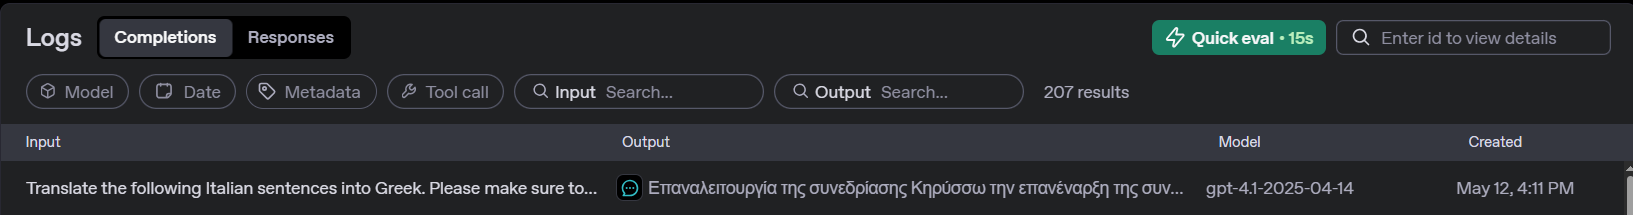

* It is not ideal but a possible approach, the rest is just splitting the sentences and aligning them with Bertalign.

In [4]:
from scripts.util import split_sents
from scripts.post_process import align_sents
from scripts.data_management import EuroParlManager
from os.path import join

dm = EuroParlManager()

# copy-pasting the text from OpenAI logs into a .txt file
with open('it-el.txt', 'r') as f: 
    mt_text = f.read()

mt_sents = split_sents(mt_text, lang='el')
src_sents, tgt_sents = dm.get_sentence_pairs('it', 'el', num_of_sents=400)

_ = align_sents(src_sents=src_sents, 
                tgt_sents=mt_sents, 
                src_lang='it', 
                tgt_lang='el', 
                folder_path=join('src_mt_alignments', 'ep-gpt'))

Source language: it, Number of sentences: 424
Target language: el, Number of sentences: 410
Embedding source and target text using paraphrase-multilingual-MiniLM-L12-v2 ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligned 424 it sentences to 410 el sentences

